In [1]:
import torch
from dataset import read_data
from genechat_model import GeneChatModel

device = "cuda" if torch.cuda.is_available() else "cpu"

train_data, test_data, _, _ = read_data()

model = GeneChatModel(
    gene_chunk_nt=512,
    gene_chunk_overlap=0,
    freeze_gene_encoder=True,
).to(device)

state = torch.load("genechat_checkpoints/model_best.pt", map_location=device)
model.load_state_dict(state)

example1 = test_data[10]
example2 = test_data[200]

for ex_i, ex in enumerate([example1, example2], start=1):
    dna = ex["dna"]
    target = ex["target"]
    print(f"\n=== Example {ex_i} Ground Truth ===")
    print(target)

    gen = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.8,
        top_k=50,
    )
    print(f"\n=== Example {ex_i} Model Output ===")
    print(gen)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_114/992382303.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=


=== Example 1 Ground Truth ===
This genomic region was validated as an active enhancer by the ChIP-STARR-seq massively parallel reporter assay in naive human embryonic stem cells. This enhancer is marked by the H3K27ac and H3K4me1 histone modifications.

=== Example 1 Model Output ===
of insulin secretion; and negative regulation of signal transduction. Predicted to be located in cytoplasm. Predicted to be active in plasma membrane. Is expressed in intestinal bulb. Orthologous to human SLC17A1 (solute carrier family 17 member 1). Human ortholog(

=== Example 2 Ground Truth ===
This genomic sequence was predicted to be a transcriptional regulatory region based on chromatin state analysis from the ENCODE (ENCyclopedia Of DNA Elements) project. It was validated as a functional repressive element by the Sharpr-MPRA technique (Systematic high-resolution activation and repression profiling with reporter tiling using massively parallel reporter assays) in K562 erythroleukemia cells (group: K

In [5]:
# model.eval()
# !pip install sacrebleu rouge-score nltk matplotlib tqdm

In [6]:
import nltk
nltk.download('wordnet', download_dir='/home/jovyan/nltk_data')
nltk.data.path.append('/home/jovyan/nltk_data')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
NUM_SAMPLES = 10
random_indices = random.sample(range(len(test_data)), NUM_SAMPLES)
metrics_list = []

for idx in random_indices:
    ex = test_data[idx]
    dna = ex["dna"]
    ref = ex["target"]

    pred = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.7,
        top_k=50,
    )

    m = compute_metrics(ref, pred)
    metrics_list.append(m)

    print(f"\n--- Sample idx {idx} ---")
    print("Ground Truth:", ref[:200].replace("\n"," ") + "...")
    print("Prediction:  ", pred[:200].replace("\n"," ") + "...")
    print("Metrics:", m)



--- Sample idx 2525 ---
Ground Truth: Enables protein serine/threonine kinase activity. Involved in several processes, including learning; regionalization; and regulation of signal transduction. Located in several cellular components, inc...
Prediction:   of TOR signaling. Located in cytosol; endosome; and plasma membrane. Orthologous to human HSPT (heat shock protein tyrosine kinase). Orthologous to human HSPT2 (heat shock protein tyrosine kinase fami...
Metrics: {'bleu1': 0.0921079069525679, 'bleu2': 0.05106111073092441, 'bleu3': 0.029323934632295882, 'bleu4': 0.015813284462165095, 'meteor': 0.0657030223390276, 'rouge1': 0.22033898305084743, 'rougeL': 0.16949152542372883}

--- Sample idx 544 ---
Ground Truth: This gene encodes a member of the Kunitz-type serine proteinase inhibitor family. The protein can inhibit a variety of serine proteases including factor VIIa/tissue factor, factor Xa, plasmin, trypsin...
Prediction:   saccharide; response to lipopolysaccharide; and response to 

In [7]:
import random, numpy as np
from sacrebleu import BLEU
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# BLEU scorers for BLEU-1..4
bleu1 = BLEU(max_ngram_order=1, effective_order=True)
bleu2 = BLEU(max_ngram_order=2, effective_order=True)
bleu3 = BLEU(max_ngram_order=3, effective_order=True)
bleu4 = BLEU(max_ngram_order=4, effective_order=True)

# ROUGE scorer
rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

def compute_metrics(ref, pred):
    """Compute BLEU-n, METEOR, ROUGE-1, ROUGE-L."""

    # BLEU scores
    b1 = bleu1.sentence_score(pred, [ref]).score / 100
    b2 = bleu2.sentence_score(pred, [ref]).score / 100
    b3 = bleu3.sentence_score(pred, [ref]).score / 100
    b4 = bleu4.sentence_score(pred, [ref]).score / 100

    # METEOR
    ref_tok = ref.split()
    pred_tok = pred.split()
    meteor = meteor_score([ref_tok], pred_tok)

    # ROUGE
    r = rouge.score(ref, pred)
    rouge1 = r["rouge1"].fmeasure
    rougeL = r["rougeL"].fmeasure

    return {
        "bleu1": b1,
        "bleu2": b2,
        "bleu3": b3,
        "bleu4": b4,
        "meteor": meteor,
        "rouge1": rouge1,
        "rougeL": rougeL,
    }


# Storage lists
bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores = [], [], [], []
meteor_scores = []
rouge1_scores, rougeL_scores = [], []


# Loop through dataset
for ex in tqdm(test_data):
    dna = ex["dna"]
    ref = ex["target"]

    pred = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.7,
        top_k=50,
    )

    m = compute_metrics(ref, pred)

    bleu1_scores.append(m["bleu1"])
    bleu2_scores.append(m["bleu2"])
    bleu3_scores.append(m["bleu3"])
    bleu4_scores.append(m["bleu4"])

    meteor_scores.append(m["meteor"])

    rouge1_scores.append(m["rouge1"])
    rougeL_scores.append(m["rougeL"])




100%|██████████| 4106/4106 [48:34<00:00,  1.41it/s] 



===== AVERAGE METRICS =====
BLEU-1:   0.1560
BLEU-2:   0.0837
BLEU-3:   0.0569
BLEU-4:   0.0415
METEOR:   0.1165
ROUGE-1:  0.1916
ROUGE-L:  0.1480


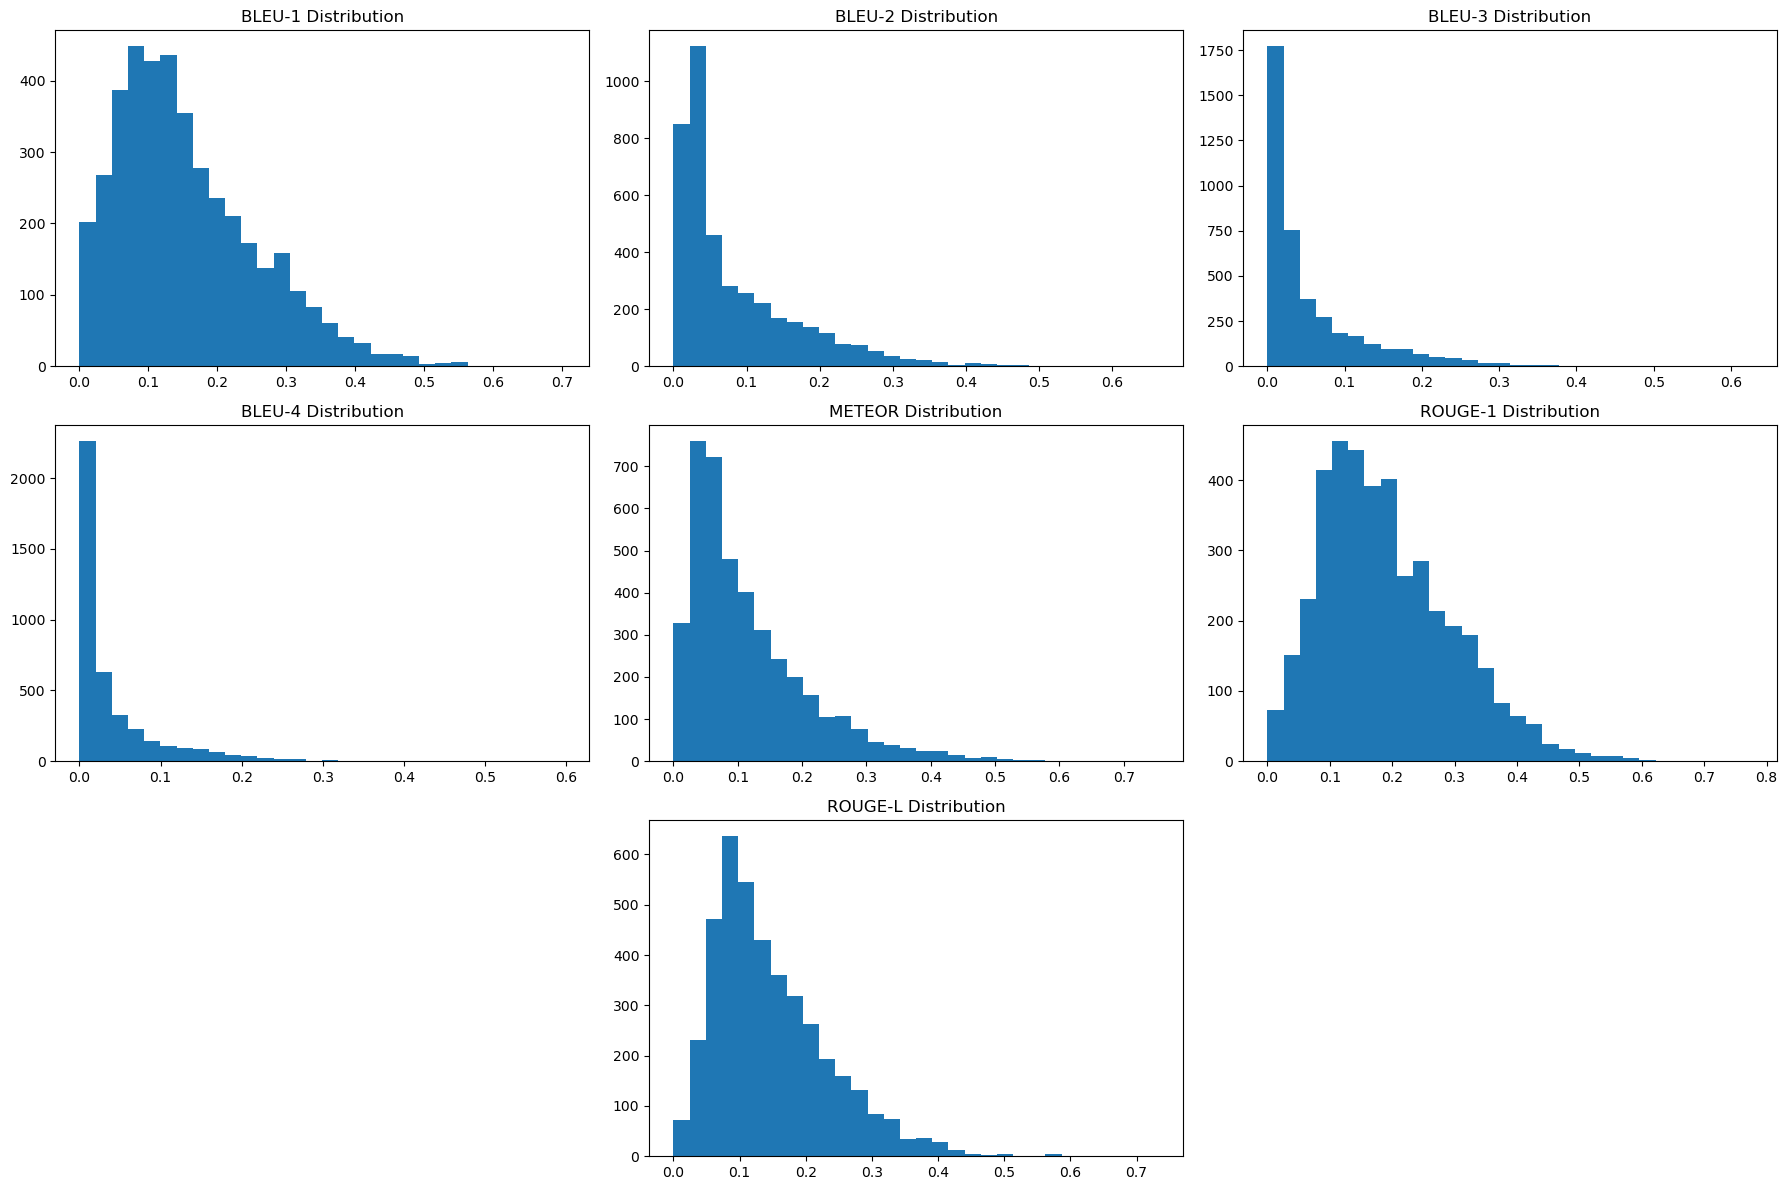

In [10]:
# ==== AVERAGES ====
avg_bleu1   = np.mean(bleu1_scores)
avg_bleu2   = np.mean(bleu2_scores)
avg_bleu3   = np.mean(bleu3_scores)
avg_bleu4   = np.mean(bleu4_scores)
avg_meteor  = np.mean(meteor_scores)
avg_rouge1  = np.mean(rouge1_scores)
avg_rougeL  = np.mean(rougeL_scores)

print("\n===== AVERAGE METRICS =====")
print(f"BLEU-1:   {avg_bleu1:.4f}")
print(f"BLEU-2:   {avg_bleu2:.4f}")
print(f"BLEU-3:   {avg_bleu3:.4f}")
print(f"BLEU-4:   {avg_bleu4:.4f}")
print(f"METEOR:   {avg_meteor:.4f}")
print(f"ROUGE-1:  {avg_rouge1:.4f}")
print(f"ROUGE-L:  {avg_rougeL:.4f}")


# ==== HISTOGRAMS ====

plt.figure(figsize=(18,12))

# Row 1 — BLEU scores
plt.subplot(3,3,1)
plt.hist(bleu1_scores, bins=30)
plt.title("BLEU-1 Distribution")

plt.subplot(3,3,2)
plt.hist(bleu2_scores, bins=30)
plt.title("BLEU-2 Distribution")

plt.subplot(3,3,3)
plt.hist(bleu3_scores, bins=30)
plt.title("BLEU-3 Distribution")

# Row 2 — BLEU-4, METEOR, ROUGE-1
plt.subplot(3,3,4)
plt.hist(bleu4_scores, bins=30)
plt.title("BLEU-4 Distribution")

plt.subplot(3,3,5)
plt.hist(meteor_scores, bins=30)
plt.title("METEOR Distribution")

plt.subplot(3,3,6)
plt.hist(rouge1_scores, bins=30)
plt.title("ROUGE-1 Distribution")

# Row 3 — ROUGE-L only (centered)
plt.subplot(3,3,8)
plt.hist(rougeL_scores, bins=30)
plt.title("ROUGE-L Distribution")

plt.tight_layout()
plt.show()